In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy
import dsharp_opac as opacity
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

fortran mie routines unavailable


/data/discsim2/fz258/.conda/envs/bayesian_analysis/lib/python3.9/site-packages/dsharp_opac/dsharp_opac.py:42: UserWarning: could not import compiled mie code - mie calculation will be slow
  warnings.warn('could not import compiled mie code - mie calculation will be slow')


In [2]:
%matplotlib inline
%matplotlib notebook

In [3]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 2.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.5})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.5})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.5})
plt.rcParams.update({'ytick.minor.width': 1.5})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

Constants (from here: https://docs.astropy.org/en/stable/constants/index.html#module-astropy.constants)

In [4]:
au    = 1.49597871e+13         #cm
c_vel = 29979245800.0          #cm/s
h_pl  = 6.62607015e-27         #erg s
k_B   = 1.380649e-16           #erg/K
lsun  = 3.828e+33              #erg/s
s_SB  = 5.6703744191844314e-05 #g/K4/s3
grav  = 6.674299999999999e-08  #cm3 / (g s2)
m_sun = 1.988409870698051e+33  #g
mprot = 1.67262192369e-24      #g

In [5]:
freq  = np.array([338.228441,229.612176,97.5043346,33.0005835])

In [6]:
disc_PA   = 11.28   #p.a. from Cathie's paper
disc_inc  = 49.24   #inclination from Cathie's paper
disc_dist = 160.318 #pc

Scattering model:

In [7]:
def BlackBody(nu, temp):
    """ 
    Returns Planck's function in Jy/sr.
    Parameters:
    nu:   frequency in GHz
    temp: temperature in K
    """
    den = np.exp(h_pl*nu*1e9/(k_B*temp)) - 1.
    num = 2.*h_pl*(nu*1e9)**3/c_vel**2  # in erg/cm^2 = erg/(cm^2*Hz*s*sr)

    planck = num/den
    return planck*1e23  # in Jy/sr

In [8]:
def scattering_function(omega, tau, mu=np.cos(disc_inc*np.pi/180.)):
    """
    Returns physical model for dust emission due to absorption and scattering (from slab's approximation).
    See e.g. Equation 3 of Macías et al. 2021.
    Parameters:
    omega: single-scattering albedo
    tau:   total optical depth
    mu:    cosine of the inclination
    """
    epsilon = (1. - omega)**0.5
    
    _a = np.exp(-np.sqrt(3.)*epsilon*tau)*(epsilon-1.) - (epsilon+1.)

    _b = (1. - np.exp(-(np.sqrt(3.)*epsilon+1./mu)*tau))/(np.sqrt(3.)*epsilon*mu + 1. + 1e-300)

    _c = (np.exp(-tau/mu)-np.exp(-np.sqrt(3.)*epsilon*tau))/(np.sqrt(3.)*epsilon*mu - 1. + 1e-300)

    _f = (_b+_c)/(_a + 1e-300)

    return 1. - np.exp(-tau/mu) + omega * _f

In [9]:
d         = np.load('/data/discsim2/fz258/dsharp_opac_notebook/datafiles/opacity_Ricci_compact(mine).npz')
a         = d['a']
lam       = d['lam']
k_abs     = d['k_abs']
k_sca     = d['k_sca']
gsca      = d['g']
k_sca_eff = (1 - gsca) * k_sca

In [10]:
def fitting_function(freq_avg, temp, lsigma, lamax, q):
    '''
    Returns intensity at a given radius in Jy/sr. See Macias et al. 2021 and Carrasco-Gonzalez et al. 2019.
    Parameters:
    freq_avg: average frequency of observations in GHz; *must be in decreasing order* (because size_averaga_opacity orders opacities with lambda)
    temp:     dust midplane temperature in K
    lsigma:   log10 of dust surface density in g/cm2
    lamax:    log10 of maximum grain size in cm
    q:        grain size 
    '''
    lam_avg   = c_vel/(freq_avg*1e9)
    res_eff   = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca_eff, q=q, plot=False)
    omg_eff   = res_eff['ks'] / (res_eff['ka'] + res_eff['ks']) #albedo
    opc_eff   = res_eff['ka'] + res_eff['ks']                   #total dust opacity (absorption + scattering)
    opc_abs   = res_eff['ka']                                   #absorption opacity
    
    omg_init  = np.array([np.interp(lamax,np.log10(a),omg_eff[i]) for i in range(len(freq_avg))])
    opc_init  = np.array([np.interp(lamax,np.log10(a),opc_eff[i]) for i in range(len(freq_avg))])
    abs_init  = np.array([np.interp(lamax,np.log10(a),opc_abs[i]) for i in range(len(freq_avg))])
    
    tau       = opc_init*10.**lsigma
    tau_abs   = abs_init*10.**lsigma
    chi       = scattering_function(omega=omg_init,tau=tau)
    bb        = BlackBody(nu=freq_avg,temp=temp)

    inu_init  = bb * chi

    return inu_init, tau, omg_init, opc_init, abs_init, tau_abs

In [11]:
rad_grid  = np.loadtxt('radprof_Band3.dat',unpack=True,skiprows=1,usecols=0)

inu_sum, med_i, e16_i, e84_i, med_t, e16_t, e84_t, med_a, e16_a, e84_a, med_o, e16_o, e84_o, med_k, e16_k, e84_k, med_tk, e16_tk, e84_tk = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
for bin_idx in range(101):
        
    print('Now running: {}'.format(bin_idx))
    
    rad     = rad_grid[bin_idx]

    reader  = emcee.backends.HDFBackend('./chains/CITau_SEDfit_{}.hdf5'.format(rad), read_only=True)
    tau     = reader.get_autocorr_time(tol=0)

    burnin  = int(5 * np.max(tau))
    thin    = int(0.5 * np.min(tau))       

    flat_samples = reader.get_chain(discard=burnin, thin=thin, flat=True)
    
    inu_fit = np.zeros((4,len(flat_samples[:,0])))

    tau_fit = np.zeros((4,len(flat_samples[:,0])))
    
    omg_fit = np.zeros((4,len(flat_samples[:,0])))
    
    opc_fit = np.zeros((4,len(flat_samples[:,0])))
    
    abs_fit = np.zeros((4,len(flat_samples[:,0])))
    
    tauabs_fit = np.zeros((4,len(flat_samples[:,0])))

    for i in range(len(flat_samples[:,0])):
        inu_fit[:,i], tau_fit[:,i], omg_fit[:,i], opc_fit[:,i], abs_fit[:,i], tauabs_fit[:,i] = fitting_function(
                freq_avg = freq, 
                temp     = flat_samples[i,0], 
                lsigma   = flat_samples[i,1], 
                lamax    = flat_samples[i,2], 
                q        = flat_samples[i,3],
            )
    
    inu_sum.append(inu_fit)
    
    med_i.append(np.percentile(inu_fit,50,axis=1))
    e16_i.append(np.percentile(inu_fit,16,axis=1))
    e84_i.append(np.percentile(inu_fit,84,axis=1))
    
    med_t.append(np.percentile(tau_fit,50,axis=1))
    e16_t.append(np.percentile(tau_fit,16,axis=1))
    e84_t.append(np.percentile(tau_fit,84,axis=1))
    
    med_a.append(np.percentile(omg_fit,50,axis=1))
    e16_a.append(np.percentile(omg_fit,16,axis=1))
    e84_a.append(np.percentile(omg_fit,84,axis=1))
    
    med_o.append(np.percentile(opc_fit,50,axis=1))
    e16_o.append(np.percentile(opc_fit,16,axis=1))
    e84_o.append(np.percentile(opc_fit,84,axis=1))
    
    med_k.append(np.percentile(abs_fit,50,axis=1))
    e16_k.append(np.percentile(abs_fit,16,axis=1))
    e84_k.append(np.percentile(abs_fit,84,axis=1))
    
    med_tk.append(np.percentile(tauabs_fit,50,axis=1))
    e16_tk.append(np.percentile(tauabs_fit,16,axis=1))
    e84_tk.append(np.percentile(tauabs_fit,84,axis=1))

Now running: 0
Now running: 1
Now running: 2
Now running: 3
Now running: 4
Now running: 5
Now running: 6
Now running: 7
Now running: 8
Now running: 9
Now running: 10
Now running: 11
Now running: 12
Now running: 13
Now running: 14
Now running: 15
Now running: 16
Now running: 17
Now running: 18
Now running: 19
Now running: 20
Now running: 21
Now running: 22
Now running: 23
Now running: 24
Now running: 25
Now running: 26
Now running: 27
Now running: 28
Now running: 29
Now running: 30
Now running: 31
Now running: 32
Now running: 33
Now running: 34
Now running: 35
Now running: 36
Now running: 37
Now running: 38
Now running: 39
Now running: 40
Now running: 41
Now running: 42
Now running: 43
Now running: 44
Now running: 45
Now running: 46
Now running: 47
Now running: 48
Now running: 49
Now running: 50
Now running: 51
Now running: 52
Now running: 53
Now running: 54
Now running: 55
Now running: 56
Now running: 57
Now running: 58
Now running: 59
Now running: 60
Now running: 61
Now running: 62
No

In [12]:
med_i = np.array(med_i)
e16_i = np.array(e16_i)
e84_i = np.array(e84_i)

med_t = np.array(med_t)
e16_t = np.array(e16_t)
e84_t = np.array(e84_t)

med_a = np.array(med_a)
e16_a = np.array(e16_a)
e84_a = np.array(e84_a)

med_o = np.array(med_o)
e16_o = np.array(e16_o)
e84_o = np.array(e84_o)

med_k = np.array(med_k)
e16_k = np.array(e16_k)
e84_k = np.array(e84_k)

med_tk = np.array(med_tk)
e16_tk = np.array(e16_tk)
e84_tk = np.array(e84_tk)

In [13]:
a67_med,  a67_p16,  a67_p84  = [], [], []
a73_med,  a73_p16,  a73_p84  = [], [], []
a63_med,  a63_p16,  a63_p84  = [], [], []
a3Ka_med, a3Ka_p16, a3Ka_p84 = [], [], []

for i in range(len(inu_sum)):
    print('Now running: {}'.format(i))
    
    alpha67  = np.log(inu_sum[i][0]/inu_sum[i][1])/np.log(freq[0]/freq[1])
    a67_med.append(np.percentile(alpha67,50))
    a67_p16.append(np.percentile(alpha67,16))
    a67_p84.append(np.percentile(alpha67,84))
    
    alpha73  = np.log(inu_sum[i][0]/inu_sum[i][2])/np.log(freq[0]/freq[2])
    a73_med.append(np.percentile(alpha73,50))
    a73_p16.append(np.percentile(alpha73,16))
    a73_p84.append(np.percentile(alpha73,84))

    alpha63  = np.log(inu_sum[i][1]/inu_sum[i][2])/np.log(freq[1]/freq[2])
    a63_med.append(np.percentile(alpha63,50))
    a63_p16.append(np.percentile(alpha63,16))
    a63_p84.append(np.percentile(alpha63,84))
    
    alpha3Ka = np.log(inu_sum[i][2]/inu_sum[i][3])/np.log(freq[2]/freq[3])
    a3Ka_med.append(np.percentile(alpha3Ka,50))
    a3Ka_p16.append(np.percentile(alpha3Ka,16))
    a3Ka_p84.append(np.percentile(alpha3Ka,84))
    
a67_med = np.array(a67_med)  
a67_p16 = np.array(a67_p16)
a67_p84 = np.array(a67_p84)

a73_med = np.array(a73_med)  
a73_p16 = np.array(a73_p16)
a73_p84 = np.array(a73_p84)

a63_med = np.array(a63_med)  
a63_p16 = np.array(a63_p16)
a63_p84 = np.array(a63_p84)

a3Ka_med = np.array(a3Ka_med)  
a3Ka_p16 = np.array(a3Ka_p16)
a3Ka_p84 = np.array(a3Ka_p84)

Now running: 0
Now running: 1
Now running: 2
Now running: 3
Now running: 4
Now running: 5
Now running: 6
Now running: 7
Now running: 8
Now running: 9
Now running: 10
Now running: 11
Now running: 12
Now running: 13
Now running: 14
Now running: 15
Now running: 16
Now running: 17
Now running: 18
Now running: 19
Now running: 20
Now running: 21
Now running: 22
Now running: 23
Now running: 24
Now running: 25
Now running: 26
Now running: 27
Now running: 28
Now running: 29
Now running: 30
Now running: 31
Now running: 32
Now running: 33
Now running: 34
Now running: 35
Now running: 36
Now running: 37
Now running: 38
Now running: 39
Now running: 40
Now running: 41
Now running: 42
Now running: 43
Now running: 44
Now running: 45
Now running: 46
Now running: 47
Now running: 48
Now running: 49
Now running: 50
Now running: 51
Now running: 52
Now running: 53
Now running: 54
Now running: 55
Now running: 56
Now running: 57
Now running: 58
Now running: 59
Now running: 60
Now running: 61
Now running: 62
No

In [14]:
np.savetxt(
    './results/intensity_tapered_bandKa_nof_cut.dat',
    np.array([rad_grid[:101],med_i[:,0],e16_i[:,0],e84_i[:,0],med_i[:,1],e16_i[:,1],e84_i[:,1],med_i[:,2],e16_i[:,2],e84_i[:,2],med_i[:,3],e16_i[:,3],e84_i[:,3]]).T,
    header = 'rad [au]\ti7 [Jy/Sr]\te16 [Jy/Sr]\te84 [Jy/Sr]\ti6 [Jy/Sr]\te16 [Jy/Sr]\te84 [Jy/Sr]\ti3 [Jy/Sr]\te16 [Jy/Sr]\te84 [Jy/Sr]\tiKa [Jy/Sr]\te16 [Jy/Sr]\te84 [Jy/Sr]'
)

np.savetxt(
    './results/spectral_index_tapered_bandKa_nof_cut.dat',
    np.array([rad_grid[:101],a67_med,a67_p16,a67_p84,a63_med,a63_p16,a63_p84,a3Ka_med,a3Ka_p16,a3Ka_p84]).T,
    header = 'rad [au]\talpha76\te16\te84\talpha63\te16\te84\talpha3Ka\te16\te84'
)

np.savetxt(
    './results/tau_tapered_bandKa_nof_cut.dat',
    np.array([rad_grid[:101],med_t[:,0],e16_t[:,0],e84_t[:,0],med_t[:,1],e16_t[:,1],e84_t[:,1],med_t[:,2],e16_t[:,2],e84_t[:,2],med_t[:,3],e16_t[:,3],e84_t[:,3]]).T,
    header = 'rad [au]\ttau7\te16\te84\ttau6\te16\te84\ttau3\te16\te84\ttauKa\te16\te84'
)

np.savetxt(
    './results/tauabs_tapered_bandKa_nof_cut.dat',
    np.array([rad_grid[:101],med_tk[:,0],e16_tk[:,0],e84_tk[:,0],med_tk[:,1],e16_tk[:,1],e84_tk[:,1],med_tk[:,2],e16_tk[:,2],e84_tk[:,2],med_tk[:,3],e16_tk[:,3],e84_tk[:,3]]).T,
    header = 'rad [au]\ttauabs7\te16\te84\ttauabs6\te16\te84\ttauabs3\te16\te84\ttauabsKa\te16\te84'
)

np.savetxt(
    './results/albedo_tapered_bandKa_nof_cut.dat',
    np.array([rad_grid[:101],med_a[:,0],e16_a[:,0],e84_a[:,0],med_a[:,1],e16_a[:,1],e84_a[:,1],med_a[:,2],e16_a[:,2],e84_a[:,2],med_a[:,3],e16_a[:,3],e84_a[:,3]]).T,
    header = 'rad [au]\tomg7\te16\te84\tomg6\te16\te84\tomg3\te16\te84\tomg\te16\te84'
)

np.savetxt(
    './results/opacity_tapered_bandKa_nof_cut.dat',
    np.array([rad_grid[:101],med_o[:,0],e16_o[:,0],e84_o[:,0],med_o[:,1],e16_o[:,1],e84_o[:,1],med_o[:,2],e16_o[:,2],e84_o[:,2],med_o[:,3],e16_o[:,3],e84_o[:,3]]).T,
    header = 'rad [au]\topac7 [cm2/g]\te16 [cm2/g]\te84 [cm2/g]\topac6 [cm2/g]\te16 [cm2/g]\te84 [cm2/g]\topac3 [cm2/g]\te16 [cm2/g]\te84 [cm2/g]\topacKa [cm2/g]\te16 [cm2/g]\te84 [cm2/g]'
)

np.savetxt(
    './results/absopacity_tapered_bandKa_nof_cut.dat',
    np.array([rad_grid[:101],med_k[:,0],e16_k[:,0],e84_k[:,0],med_k[:,1],e16_k[:,1],e84_k[:,1],med_k[:,2],e16_k[:,2],e84_k[:,2],med_k[:,3],e16_k[:,3],e84_k[:,3]]).T,
    header = 'rad [au]\topac7 [cm2/g]\te16 [cm2/g]\te84 [cm2/g]\topac6 [cm2/g]\te16 [cm2/g]\te84 [cm2/g]\topac3 [cm2/g]\te16 [cm2/g]\te84 [cm2/g]\topacKa [cm2/g]\te16 [cm2/g]\te84 [cm2/g]'
)

<IPython.core.display.Javascript object>


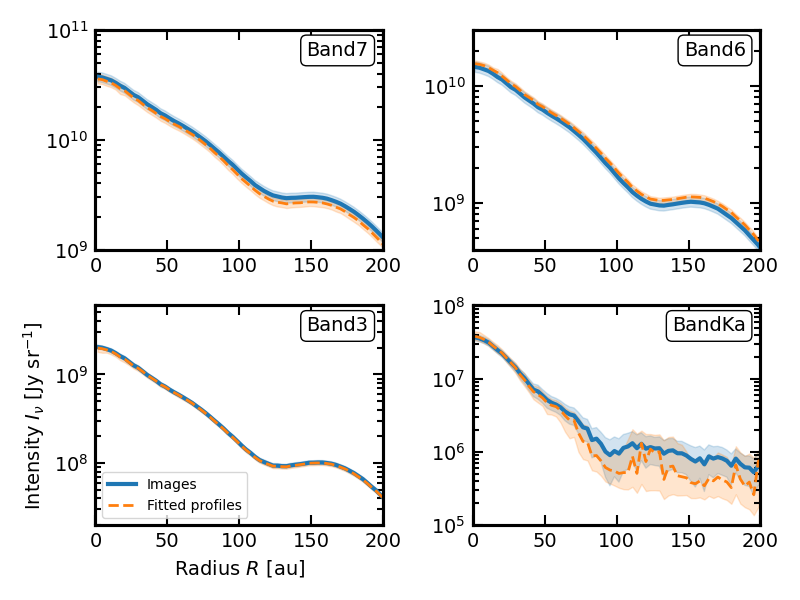

In [15]:
profiles_CITau = [
    'radprof_Band7.dat',
    'radprof_Band6.dat',
    'radprof_Band3.dat',
    'radprof_BandKa.dat',
]

label  = ['Band7', 'Band6', 'Band3', 'BandKa']

ymin   = [4e7, 4e6, 1e6,5e3]
ymax   = [1e11,3e10,8e9,3e8]

calerr = [0.10,0.10,0.05,0.10]

fig, axs = plt.subplots(2,2,figsize=(8.,6.))
axs = axs.ravel()

y_tot  = np.zeros((4,1200))
dy_tot = np.zeros((4,1200))

for idx in range(len(profiles_CITau)):

    x, y, dy = np.loadtxt(profiles_CITau[idx], skiprows=1, usecols=(0,1,2), unpack=True)
    
    y_tot[idx] = y
    dy_tot[idx] = np.hypot(dy,y*calerr[idx])
    
    l, = axs[idx].semilogy(x, y, lw=3., label='Images')
    axs[idx].fill_between(x, y - np.hypot(dy,y*calerr[idx]), y + np.hypot(dy,y*calerr[idx]), color=l.get_color(), alpha=0.2)

    axs[idx].set_xlim(0.,200.)
    axs[idx].set_ylim(ymin[idx],ymax[idx])

    axs[idx].text(0.95, 0.95, s=label[idx], ha='right', va='top', transform=axs[idx].transAxes, bbox=dict(boxstyle="round", ec="k", fc="w",))

    l, = axs[idx].semilogy(rad_grid[:101], med_i[:,idx], lw=2, ls='--', label='Fitted profiles')
    axs[idx].fill_between(rad_grid[:101],  e16_i[:,idx], e84_i[:,idx], color=l.get_color(), alpha=0.2)

axs[2].set_xlabel(r'Radius $R$ [au]')
axs[2].set_ylabel(r'Intensity $I_\nu$ [Jy sr$^{-1}$]')

axs[2].legend(loc='lower left', fontsize=10)

axs[0].set_ylim(1e9,1e11)
axs[1].set_ylim(4e8,3e10)
axs[2].set_ylim(2e7,6e9)
axs[3].set_ylim(1e5,1e8)

fig.tight_layout()
plt.savefig('./results/checkfit_prof.pdf',bbox_inches='tight')

plt.show()

<IPython.core.display.Javascript object>


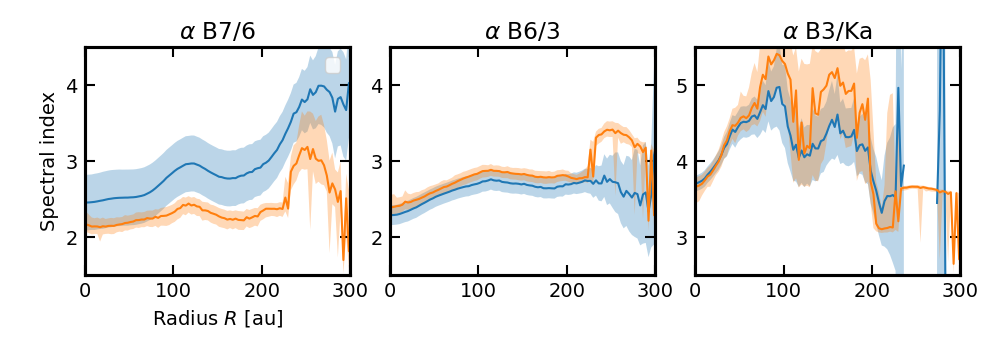

/tmp/ipykernel_20406/3126383523.py:8: RuntimeWarning: invalid value encountered in log
  a63_dat = np.log(y_tot[1,:101]/y_tot[2,:101])/np.log(freq[1]/freq[2])
/tmp/ipykernel_20406/3126383523.py:13: RuntimeWarning: invalid value encountered in log
  a3Ka_dat = np.log(y_tot[2,:101]/y_tot[3,:101])/np.log(freq[2]/freq[3])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [16]:
fig, axs = plt.subplots(1,3,figsize=(10,3.5),sharex=True)

a67_dat = np.log(y_tot[0,:101]/y_tot[1,:101])/np.log(freq[0]/freq[1])
delta_a67_dat = ((dy_tot[0,:101]/y_tot[0,:101])**2 + (dy_tot[1,:101]/y_tot[1,:101])**2)**0.5/np.log(freq[0]/freq[1])
axs[0].plot(x[:101],a67_dat)
axs[0].fill_between(x[:101],a67_dat-delta_a67_dat,a67_dat+delta_a67_dat,alpha=0.3)

a63_dat = np.log(y_tot[1,:101]/y_tot[2,:101])/np.log(freq[1]/freq[2])
delta_a63_dat = ((dy_tot[1,:101]/y_tot[1,:101])**2 + (dy_tot[2,:101]/y_tot[2,:101])**2)**0.5/np.log(freq[1]/freq[2])
axs[1].plot(x[:101],a63_dat)
axs[1].fill_between(x[:101],a63_dat-delta_a63_dat,a63_dat+delta_a63_dat,alpha=0.3)

a3Ka_dat = np.log(y_tot[2,:101]/y_tot[3,:101])/np.log(freq[2]/freq[3])
delta_a3Ka_dat = ((dy_tot[2,:101]/y_tot[2,:101])**2 + (dy_tot[3,:101]/y_tot[3,:101])**2)**0.5/np.log(freq[2]/freq[3])
axs[2].plot(x[:101],a3Ka_dat)
axs[2].fill_between(x[:101],a3Ka_dat-delta_a3Ka_dat,a3Ka_dat+delta_a3Ka_dat,alpha=0.3)

axs[0].plot(rad_grid[:101],a67_med)
axs[0].fill_between(rad_grid[:101],a67_p16,a67_p84,alpha=0.3)

axs[1].plot(rad_grid[:101],a63_med)
axs[1].fill_between(rad_grid[:101],a63_p16,a63_p84,alpha=0.3)

axs[2].plot(rad_grid[:101],a3Ka_med)
axs[2].fill_between(rad_grid[:101],a3Ka_p16,a3Ka_p84,alpha=0.3)

axs[0].set_xlabel('Radius $R$ [au]')
axs[0].set_ylabel('Spectral index')

axs[0].set_xlim(0,300)
axs[0].set_ylim(1.5,4.5)
axs[1].set_ylim(1.5,4.5)
axs[2].set_ylim(2.5,5.5)

axs[0].set_title(r'$\alpha$ B7/6')
axs[1].set_title(r'$\alpha$ B6/3')
axs[2].set_title(r'$\alpha$ B3/Ka')

axs[0].legend()

fig.tight_layout()
plt.subplots_adjust(wspace=0.15)

plt.savefig('./results/checkfit_spix.pdf', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


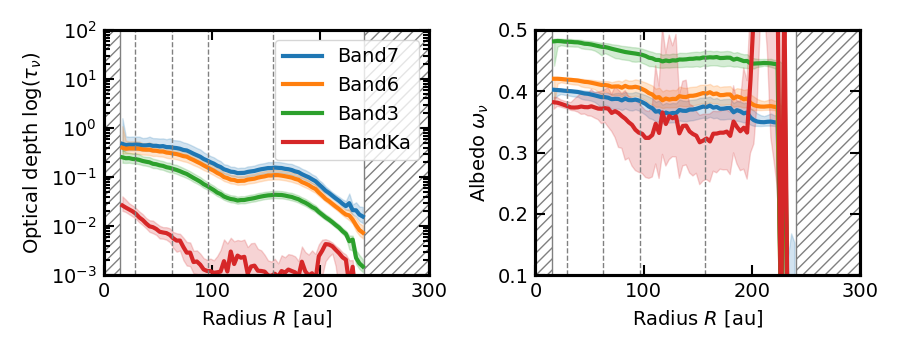

In [17]:
label  = ['Band7', 'Band6', 'Band3', 'BandKa']

mask = np.logical_and(rad_grid[:101] < 1.5*disc_dist, rad_grid[:101] > 0.095*disc_dist)

fig, axs = plt.subplots(1, 2, figsize=(9.,3.5))

for idx in range(len(label)):
    l, = axs[0].semilogy(rad_grid[:101][mask], med_t[:,idx][mask], label=label[idx], lw=3)
    axs[0].fill_between(rad_grid[:101][mask], e16_t[:,idx][mask], e84_t[:,idx][mask], color=l.get_color(), alpha=0.2)

    l, = axs[1].plot(rad_grid[:101][mask], med_a[:,idx][mask], label=label[idx], lw=3)
    axs[1].fill_between(rad_grid[:101][mask], e16_a[:,idx][mask], e84_a[:,idx][mask], color=l.get_color(), alpha=0.2)

for i in range(len(axs)):
    for loc, pos in zip([0.18,0.39,0.975,0.6],[0.05,0.05,0.77,0.82]):
        axs[i].axvline(loc*disc_dist,ls='--',c='gray',lw=1)

    axs[i].fill_betweenx(y=[1e-3,1e3],x1=0,x2=0.095*disc_dist,hatch='///',fc='white',ec='gray')
    axs[i].fill_betweenx(y=[1e-3,1e3],x1=1.5*disc_dist,x2=300,hatch='///',fc='white',ec='gray')

    axs[i].set_xlabel(r'Radius $R$ [au]')
    axs[i].set_xlim(0,300)

axs[0].set_ylabel(r'Optical depth $\log(\tau_\nu)$')
axs[0].set_ylim(1e-3,1e+2)

axs[1].set_ylabel(r'Albedo $\omega_\nu$')
axs[1].set_ylim(0.1,0.5)

axs[0].legend(loc='upper right')

fig.tight_layout()
plt.savefig('./results/optical_properties.pdf',bbox_inches='tight')

plt.show()

Test that mcmc is working correctly on the entire range:

In [18]:
def toomreQ(rad,temp,g2d=100,mass=1.29):
    """ Estimate density corresponding to Toomre Q sim 1"""
    
    cs      = np.sqrt(k_B*temp/(2.4*mprot))
    omg_kep = np.sqrt(grav*mass*m_sun/(rad*au)**3)
    
    return cs*omg_kep/(np.pi*grav*g2d)

<IPython.core.display.Javascript object>


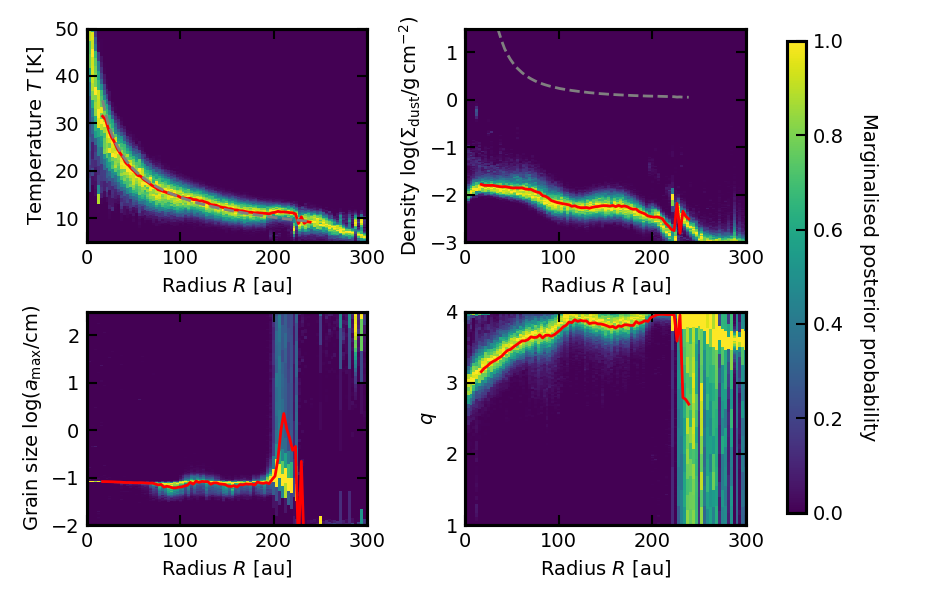

In [19]:
rad_grid  = np.loadtxt('radprof_Band3.dat',unpack=True,skiprows=1,usecols=0)
rad_edge  = rad_grid[2] - rad_grid[0]

fig, axs = plt.subplots(2,2,figsize=(9.5,6))
axs = axs.ravel()

theta_ranges = [[1.,300.], [-3.,3.], [-3.,3.], [1.,4.]]

e16, median, e84 = [], [], []
e03, e97 = [], []
for bin_idx in range(101):
    
    rad     = rad_grid[bin_idx]
    
    reader  = emcee.backends.HDFBackend('./chains/CITau_SEDfit_{}.hdf5'.format(rad), read_only=True)
    
    tau     = reader.get_autocorr_time(tol=0)

    burnin  = int(5 * np.max(tau))
    thin    = int(0.5 * np.min(tau))       

    flat_samples = reader.get_chain(discard=burnin, thin=thin, flat=True)

    for i in range(4):
        
        e16.append(np.percentile(flat_samples[:,i],16))
        median.append(np.median(flat_samples[:,i]))
        e84.append(np.percentile(flat_samples[:,i],84))

        e03.append(np.percentile(flat_samples[:,i],3))
        e97.append(np.percentile(flat_samples[:,i],97))
        
        # Plot 2D histogram
        
        bin_edges = np.histogram_bin_edges(flat_samples[:,i], bins='fd', range=tuple(theta_ranges[i]))
        
        hist, x_edges, y_edges = np.histogram2d(
            x = rad*np.ones(len(flat_samples[:,i])), 
            y = flat_samples[:,i], 
            bins = [[rad - rad_edge, rad + rad_edge], bin_edges],
        )
        
        hist /= np.amax(hist)
        hist  = hist.T
        
        xx, yy = np.meshgrid(x_edges, y_edges)
        p = axs[i].pcolormesh(xx, yy, hist, cmap='viridis', norm=Normalize(0,1))
        p.set_rasterized(True)
        
        axs[i].set_xlim(0,300)
        axs[i].set_xlabel(r'Radius $R$ [au]')
    
mask = np.logical_and(rad_grid[:101] < 1.5*disc_dist, rad_grid[:101] > 0.095*disc_dist)
median = np.array(median)

axs[0].plot(rad_grid[:101][mask], median[0::4][mask], lw=2, c='red')
axs[1].plot(rad_grid[:101][mask], median[1::4][mask], lw=2, c='red')
axs[2].plot(rad_grid[:101][mask], median[2::4][mask], lw=2, c='red')
axs[3].plot(rad_grid[:101][mask], median[3::4][mask], lw=2, c='red')

temp_prof = (0.035*1.04*lsun/(8.*np.pi*s_SB*(rad_grid*au)**2))**0.25

axs[0].plot(rad_grid[:101][mask], temp_prof[:101][mask], lw=2., ls='--', c='gray')
axs[0].set_ylim(5.,50.)

grav_100 = toomreQ(rad=rad_grid[:101][mask],temp=median[0::4][mask],g2d=100,mass=1.29)

axs[1].plot(rad_grid[:101][mask], grav_100, lw=2., ls='--', c='gray')
axs[1].set_ylim(-3,1.5)

axs[2].set_ylim(-2,2.5)

axs[0].set_ylabel(r'Temperature $T$ [K]')
axs[1].set_ylabel(r'Density $\log(\Sigma_{\rm dust}/{\rm g}\,{\rm cm}^{-2})$')
axs[2].set_ylabel(r'Grain size $\log(a_{\rm max}/{\rm cm})$')
axs[3].set_ylabel(r'$q$')

fig.tight_layout()
plt.subplots_adjust(hspace=0.325,wspace=0.35)

bar = fig.colorbar(mappable=p, ax=axs, shrink=0.95, aspect=25)
bar.set_label(label='Marginalised posterior probability', rotation=270, labelpad=25)
bar.solids.set_rasterized(True)

plt.savefig('./results/posterior_distribution.pdf',bbox_inches='tight')
plt.show()

In [20]:
np.savetxt(
    './results/tapered_bandKa_nof_cut.dat', 
    np.array([rad_grid[:101],
              median[0::4],e16[0::4],e84[0::4],
              median[1::4],e16[1::4],e84[1::4],
              median[2::4],e16[2::4],e84[2::4],
              median[3::4],e16[3::4],e84[3::4]]).T,
    header = 'rad [au]\ttemp [K]\te16_temp [K]\te84_temp [K]\tsigma [g/cm2]\te16_sigma [g/cm2]\te84_sigma [g/cm2]\tamax [cm]\te16_amax [cm]\te84_amax [cm]\tq\te16_q\te84q'
)

In [21]:
np.savetxt(
    './results/tapered_bandKa_nof_cut_3sigma.dat', 
    np.array([rad_grid[:101],
              median[0::4],e03[0::4],e97[0::4],
              median[1::4],e03[1::4],e97[1::4],
              median[2::4],e03[2::4],e97[2::4],
              median[3::4],e03[3::4],e97[3::4]]).T,
    header = 'rad [au]\ttemp [K]\te16_temp [K]\te84_temp [K]\tsigma [g/cm2]\te16_sigma [g/cm2]\te84_sigma [g/cm2]\tamax [cm]\te16_amax [cm]\te84_amax [cm]\tq\te16_q\te84q'
)